#  泰坦尼克号数据探索

## 本文旨在探索泰坦尼克号乘客的生存率的影响因素，全文分为三大部分：
#### 一、数据概况；
#### 二、数据探索；
#### 三、结论；


## 一、数据概况；

In [1]:
# 引入必要的库
import numpy  as  np
import pandas  as  pd
import matplotlib.pyplot  as  plt
import seaborn  as  sns

%pylab inline

# 导入csv文件的数据，并查看
titanic_df = pd.read_csv('titanic-data.csv')
titanic_df.head()

Populating the interactive namespace from numpy and matplotlib


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 查看数据的基本信息
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [3]:
# 先简单看下数据的基本统计学信息；
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
titanic_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Graham, Mr. George Edward",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


可以找出几个有用的信息：
 1. 乘客平均的生存率为0.38；
 2. 大部分数据有891个，较为齐全；
 3. 年龄 和 登船港口 信息缺失，如需研究需要补齐；

## 二、数据探索
有4个初步的想法，文章从**4个方面**探索：
 1. **妇女更有可能生存**；
 2. **儿童更有可能生存**；
 3. **上层乘客更有可能生存**；
 4. **一些新想法**

### 1.性别对生存率的影响

#### （1）左图：不同性别（男 or 女）人口数量分布图:
男女比例大概为2:1，有统计意义；

#### （2）右图：不同性别的存活率图；

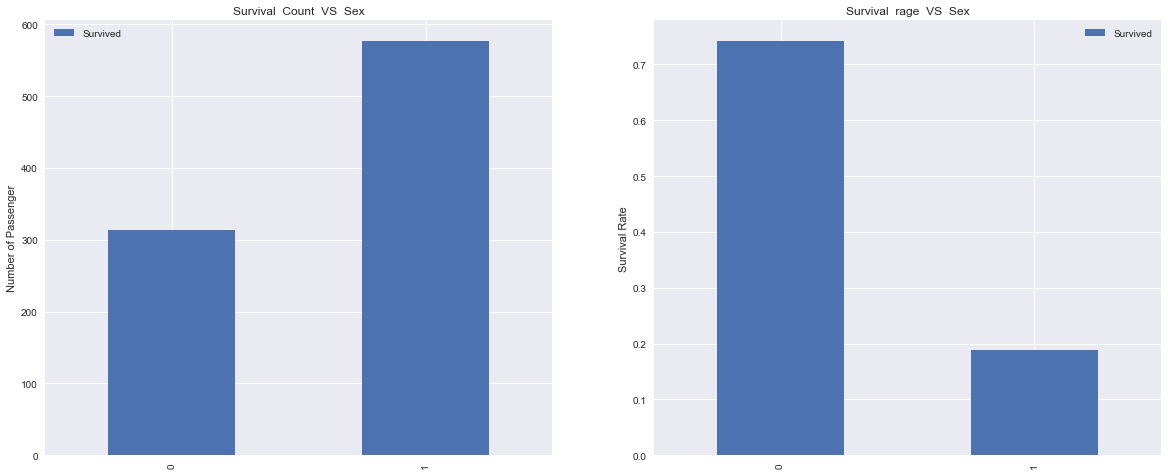

In [67]:
plt.figure(figsize = (14, 5))
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Survival  Count  VS  Sex')
ax1.set_ylabel('Number of Passenger')
ax2.set_title('Survival  rage  VS  Sex')
ax2.set_ylabel('Survival Rate')
f.set_size_inches((20, 8))
titanic_df.groupby('Sex', as_index=False)['Survived'].count().plot(kind = 'bar', ax = ax1)
titanic_df.groupby('Sex', as_index=False)['Survived'].mean().plot(kind = 'bar', ax = ax2)

女人的生存率为0.74，男人生存率为0.18，差别非常大；

**小结：**

**女士更有可能生还**

### 2. 年龄对生存率的影响
**（1）缺失值填充：**

年龄age有714个，正常有891个，需要处理缺失值，这里采用的方法是用平均值填充；

In [39]:
# 计算平均年龄 
titanic_age_mean = titanic_df['Age'].mean()

# 填充缺失值nan为平均值
titanic_df["Age"] = titanic_df["Age"].fillna(titanic_age_mean)

# 转换年龄的格式从float 到 int
titanic_df['Age']  =  titanic_df['Age'].astype(int)

**（2）各年龄段生还率研究：**

* 为了方便分析，将年龄这种连续变量**转化为分类变量**；
* 创建一个**年龄段变量**，比如(0, 10], (10, 20]......然后对乘客根据年龄分组；
* 查看每个年龄段的乘客数量、生还率；

In [63]:
# 生成一个年龄段list
bins = np.arange(0, 90, 10)

# 新建Age_group变量为年龄段
titanic_df['Age_group'] = pd.cut(titanic_df['Age'], bins)

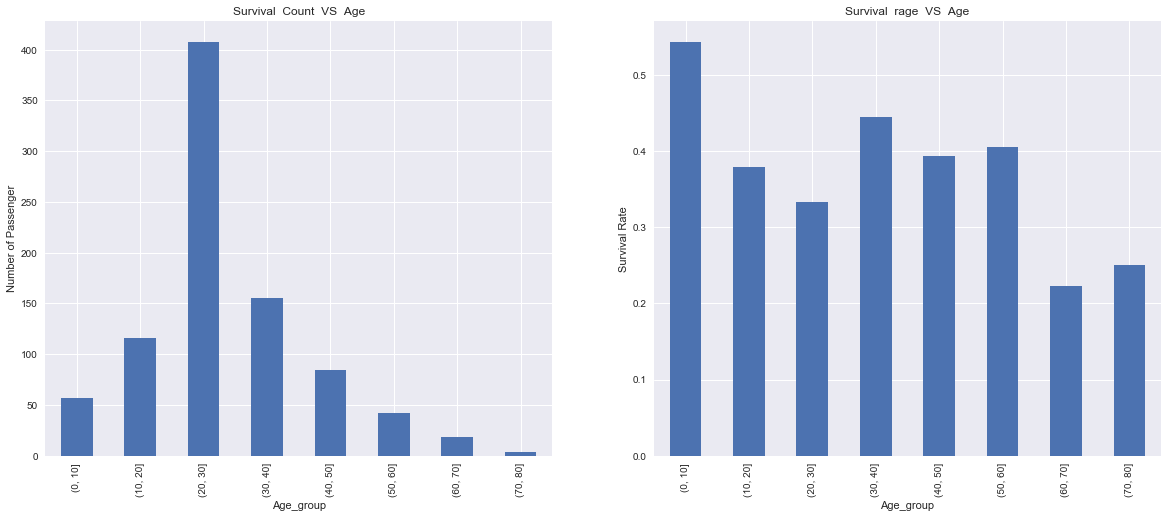

In [64]:
plt.figure(figsize = (14, 5))
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Survival  Count  VS  Age')
ax1.set_ylabel('Number of Passenger')
ax2.set_title('Survival  rage  VS  Age')
ax2.set_ylabel('Survival Rate')
f.set_size_inches((20, 8))
titanic_df.groupby('Age_group')['Survived'].count().plot(kind = 'bar', ax = ax1)
titanic_df.groupby('Age_group')['Survived'].mean().plot(kind = 'bar', ax = ax2)

从上图可以看出，在大概0-10岁的儿童，其生还的概率超过50%，超过其他年龄段；

**小结**：

**儿童更有可能生还**；

### 3.乘客所在船层对生存率的影响
#### （1）左图：不同船层乘客数量柱状图；

#### （2）右图：不同船层乘客生存率柱状图；

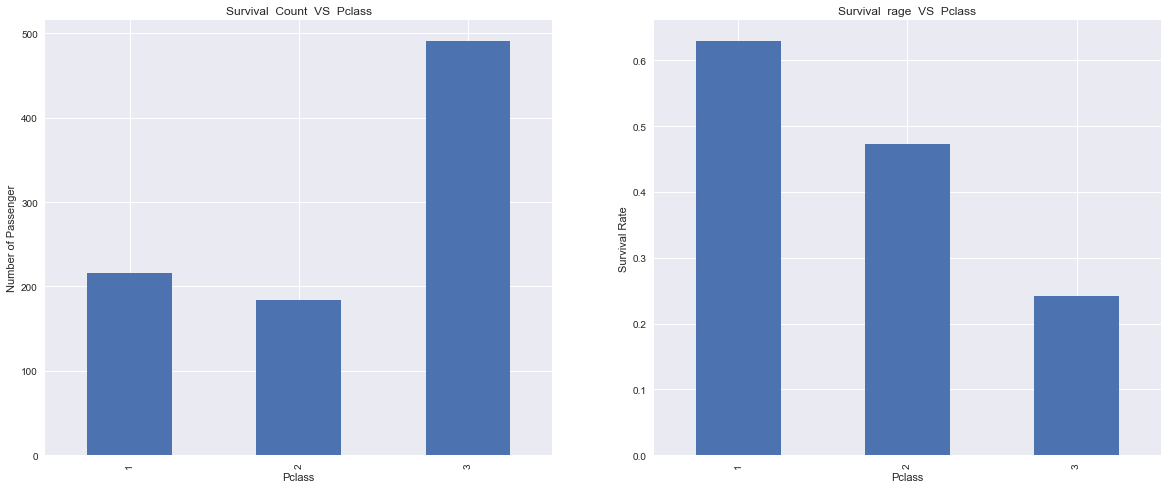

In [72]:
plt.figure(figsize = (14, 5))
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Survival  Count  VS  Pclass')
ax1.set_ylabel('Number of Passenger')
ax2.set_title('Survival  rage  VS  Pclass')
ax2.set_ylabel('Survival Rate')
f.set_size_inches((20, 8))
titanic_df.groupby('Pclass')['Survived'].count().plot(kind = 'bar', ax = ax1)
titanic_df.groupby('Pclass')['Survived'].mean().plot(kind = 'bar', ax = ax2)

不同船层的乘客生存率有显著差异：
* Pclass为1，即在 船上层 的乘客生存率为0.63；
* Pclass为2，即在 船中层 的乘客生存率为0.47；
* Pclass为3，即在 船底层 的乘客生存率为0.24；

**小结：**

** 上层乘客更有可能生存**


### 4.一些新想法 

既然性别，船层对生还率都有影响，那么她们的组合因素有没有影响呢，
所以做了以下探究：

####  左图：不同性别、船层 的乘客数量图形
####  右图：不同性别，船层 的乘客生还率图形

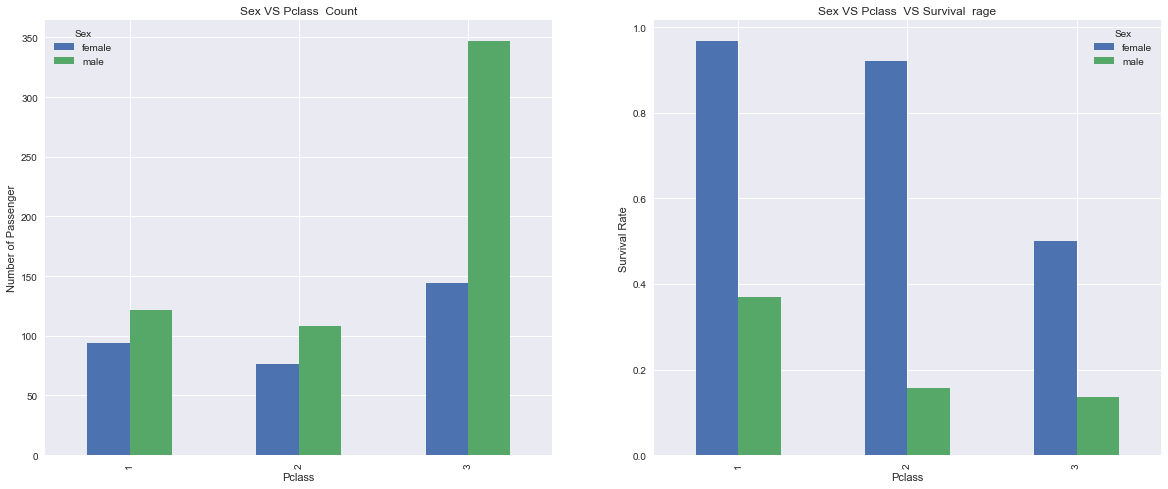

In [59]:
plt.figure(figsize(14, 5))
f, (ax1, ax2) = plt.subplots(1,2)
ax1.set_title('Sex VS Pclass  Count')
ax1.set_ylabel('Number of Passenger')
ax2.set_title('Sex VS Pclass  VS Survival  rage')
ax2.set_ylabel('Survival Rate')
f.set_size_inches((20, 8))
titanic_df.groupby(['Pclass', 'Sex'])['Survived'].count().unstack().plot(kind = 'bar', ax = ax1)
titanic_df.groupby(['Pclass', 'Sex'])['Survived'].mean().unstack().plot(kind = 'bar', ax = ax2)

可以看出，船上层 和 中层的女生绝大多数都存活下来，

且整体看 **存活率由高到低**依次是：

**(1.female) > (2,female) > (3,female) > (1,male) > (2,male) > (3,male)**

**小结：**

**无论是男性还是女性，存活率都随着pclass的增加而降低；**

## 三、结论：

 1. 本报告所用乘客数据集为891名，实际乘客为2224名，样本占总量的40.1%，可以代表整个整体，结论仍有可能有偏差，但是分析结果在统计学上可以认为是正确的；
 2. 对年龄缺失值采用平均值替代的处理可能会造成偏差，关于年龄部分的结论还需要再探究寻找更加合理的方式；
 3. 个人认为还有其他影响存活率的因素，比如：职业，地区，收入等；
 4. 真实的影响因素是多样且互相关联的，本文得出的所有结论只是很简单的分析某些变量与生存率的关系，一家之言，欢迎交流；